In [1]:
sc

<SparkContext master=spark://student-aekanun-spark-m-small:7077 appName=PySparkShell>

In [2]:
! ls -l /home/aekanun/input/chest_xray/train

total 280
drwxr-xr-x 2 aekanun aekanun  69632 Dec 31  2017 NORMAL
drwxr-xr-x 2 aekanun aekanun 208896 Jan  6  2018 PNEUMONIA


In [3]:
! ls -l /home/aekanun/chestimage/chest_xray

ls: cannot access '/home/aekanun/chestimage/chest_xray': No such file or directory


In [4]:
! ls /home/aekanun/input/chest_xray/train/NORMAL/*.jpeg | wc -l

1349


In [5]:
! ls /home/aekanun/input/chest_xray/train/PNEUMONIA/*.jpeg | wc -l

3883


In [6]:
#! ls /home/aekanun/flower_photos/tulips/*.jpg

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt #Ploting charts
from glob import glob #retriving an array of files in directories
from keras.models import Sequential #for neural network models
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator #Data augmentation and preprocessing
from keras.utils import to_categorical #For One-hot Encoding
from keras.optimizers import Adam, SGD, RMSprop #For Optimizing the Neural Network
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/home/aekanun/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [8]:
#Cheking datasets
import os
paths = os.listdir(path="/home/aekanun/input/chest_xray")
print(paths)

['test', 'train', '.DS_Store']


In [9]:
path_train = "/home/aekanun/input/chest_xray/train"
path_val = "/home/aekanun/input/chest_xray/val"
path_test = "/home/aekanun/input/chest_xray/test"

In [10]:
img = glob(path_train+"/PNEUMONIA/*.jpeg") #Getting all images in this folder

In [11]:
img

['/home/aekanun/input/chest_xray/train/PNEUMONIA/person1661_bacteria_4406.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person759_virus_1387.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person546_virus_1085.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person276_bacteria_1296.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person1454_bacteria_3779.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person763_virus_1391.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person997_virus_1678.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person51_bacteria_246.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person992_bacteria_2919.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person1019_bacteria_2950.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person702_virus_1299.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/person947_bacteria_2872.jpeg',
 '/home/aekanun/input/chest_xray/train/PNEUMONIA/perso

In [12]:
img = np.asarray(plt.imread(img[0]))

In [13]:
plt.get_backend()

'module://ipykernel.pylab.backend_inline'

In [14]:
plt.imshow(img)

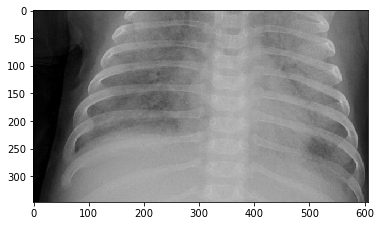

In [15]:
plt.show()

In [16]:
img.shape

(347, 607, 3)

In [17]:
img = glob(path_train+"/NORMAL/*.jpeg") #Getting all images in this folder

In [18]:
img = np.asarray(plt.imread(img[0]))

In [19]:
plt.imshow(img)

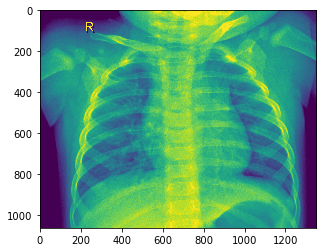

In [20]:
plt.show()

In [21]:
img.shape

(1062, 1350)

In [22]:
from pyspark.serializers import PickleSerializer

In [23]:
spark = SparkSession.builder.master("yarn").appName("AppName").\
config("spark.serializer","PickleSerializer").\
config("spark.driver.maxResultSize", "7g").\
getOrCreate()

In [24]:
normal_files = !ls /home/aekanun/input/chest_xray/train/NORMAL/*.jpeg

In [25]:
pneumonia_files = !ls /home/aekanun/input/chest_xray/train/PNEUMONIA/*.jpeg

In [26]:
normal_files

['/home/aekanun/input/chest_xray/train/NORMAL/IM-0115-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0117-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0119-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0122-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0125-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0127-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0128-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0129-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0131-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0133-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0135-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0137-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0140-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0141-0001.jpeg',
 '/home/aekanun/input/chest_xray/train/NORMAL/IM-0143-0001.jpeg',
 '/home/ae

In [27]:
from pyspark.sql.functions import lit
from sparkdl.image import imageIO
import pyspark.ml.linalg as spla
import pyspark.sql.types as sptyp
import numpy as np

def CreateTrainImageUriandLabels(image_uris, label, cardinality):
  # Create image categorical labels (integer IDs)
  local_rows = []
  for uri in image_uris:
    label_inds = np.zeros(cardinality)
    label_inds[label] = 1.0
    one_hot_vec = spla.Vectors.dense(label_inds.tolist())
    _row_struct = {"uri": uri, "one_hot_label": one_hot_vec, "label": float(label)}
    row = sptyp.Row(**_row_struct)
    local_rows.append(row)

  image_uri_df = sqlContext.createDataFrame(local_rows)
  return image_uri_df

In [28]:
label_cardinality = 2

In [29]:
normal_uri_df = CreateTrainImageUriandLabels(normal_files,0,label_cardinality)

In [30]:
normal_uri_df.count()

1349

In [31]:
pneumonia_uri_df = CreateTrainImageUriandLabels(pneumonia_files,1,label_cardinality)

In [32]:
pneumonia_uri_df.count()

3883

In [33]:
normal_uri_df.count()

1349

In [34]:
normal_train, normal_test, normal_dummy = normal_uri_df.randomSplit([0.01, 0.19, 0.8])

In [35]:
pneumonia_train, pneumonia_test, pneumonia_dummy = pneumonia_uri_df.randomSplit([0.004, 0.096, 0.9])

In [36]:
normal_train

DataFrame[label: double, one_hot_label: vector, uri: string]

In [37]:
normal_train.count()

12

In [38]:
normal_train.take(1)

[Row(label=0.0, one_hot_label=DenseVector([1.0, 0.0]), uri='/home/aekanun/input/chest_xray/train/NORMAL/IM-0133-0001.jpeg')]

In [39]:
pneumonia_train.take(1)

[Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1365_virus_2348.jpeg')]

In [40]:
pneumonia_test.take(1)

[Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1001_bacteria_2932.jpeg')]

In [41]:
pneumonia_train.count()

9

In [42]:
pneumonia_train.take(10)

[Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1365_virus_2348.jpeg'),
 Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1481_bacteria_3864.jpeg'),
 Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person1595_virus_2771.jpeg'),
 Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person337_bacteria_1564.jpeg'),
 Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person38_bacteria_195.jpeg'),
 Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person462_bacteria_1961.jpeg'),
 Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person470_bacteria_2003.jpeg'),
 Row(label=1.0, one_hot_label=De

In [43]:
train_df = normal_train.unionAll(pneumonia_train)
test_df = normal_test.unionAll(pneumonia_test)

In [44]:
train_df.count()

21

In [45]:
test_df.count()

645

In [46]:
train_df = train_df.repartition(80000)
test_df = test_df.repartition(80000)

In [47]:
! rm -rf /tmp/*.h5

In [48]:
#Import Keras Model and Customize it with Keras Layers
from keras.layers import *
from keras.models import Sequential

model = Sequential()

In [49]:
#conv-1
model.add(ZeroPadding2D((1,1),input_shape=(226, 226, 3)))
model.add(Conv2D(96, (24,24), strides=(2, 2),activation='relu'))  

#conv-2
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (1,1),activation='relu'))  
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256,(16,16),activation='relu'))

#max pool-1
model.add(MaxPooling2D((2,2),strides=(2,2))) 

In [50]:
#conv-3
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(16, (1,1),activation='relu'))  
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(384, (3,3),activation='relu'))  

#conv-4
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256,(16,16),activation='relu')) 

In [51]:
#conv-5
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(96, (24,24),activation='relu'))  

#max pool-2
model.add(ZeroPadding2D((1,1)))
model.add(MaxPooling2D((3,3),strides=(1,1))) 


In [52]:
model.add(Flatten(input_shape=(11, 11, 96)))
model.add(Dense(2))
model.add(Activation("softmax"))
model.save('/tmp/model-small.h5')  # saves to the local filesystem

In [53]:
! ls -lh /tmp/model-small.h5

-rw-rw-r-- 1 aekanun aekanun 156M Aug  7 07:31 /tmp/model-small.h5


In [54]:
import PIL.Image
import numpy as np
from keras.applications.imagenet_utils import preprocess_input

def load_image_from_uri(local_uri):
  img = (PIL.Image.open(local_uri).convert('RGB').resize((226, 226), PIL.Image.ANTIALIAS))
  img_arr = np.array(img).astype(np.float32)
  img_tnsr = preprocess_input(img_arr[np.newaxis, :])
  return img_tnsr

In [55]:
train_df

DataFrame[label: double, one_hot_label: vector, uri: string]

In [56]:
train_df.select('one_hot_label').take(5)

[Row(one_hot_label=DenseVector([0.0, 1.0])),
 Row(one_hot_label=DenseVector([1.0, 0.0])),
 Row(one_hot_label=DenseVector([1.0, 0.0])),
 Row(one_hot_label=DenseVector([1.0, 0.0])),
 Row(one_hot_label=DenseVector([1.0, 0.0]))]

In [57]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 103, 103, 96)      165984    
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 105, 105, 96)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 105, 105, 16)      1552      
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 107, 107, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 92, 92, 256)       1048832   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 256)       0         
__________

In [58]:
#load_image_from_uri('/home/aekanun/input/chest_xray/train/PNEUMONIA/person30_bacteria_152.jpeg')

In [59]:
! ls -l /tmp/model-small.h5

-rw-rw-r-- 1 aekanun aekanun 162589648 Aug  7 07:31 /tmp/model-small.h5


In [60]:
from sparkdl.estimators.keras_image_file_estimator import KerasImageFileEstimator

#dbutils.fs.cp(dbfs_model_small_path, 'file:/tmp/model-small-tmp.h5')
estimator = KerasImageFileEstimator(inputCol="uri",
                                    outputCol="prediction",
                                    labelCol="one_hot_label",
                                    imageLoader=load_image_from_uri,
                                    kerasOptimizer='adam',
                                    kerasLoss='categorical_crossentropy',
                                    kerasFitParams={'verbose':2,'epochs':25},
                                    modelFile='/tmp/model-small.h5')

In [61]:
train_df.take(3)

[Row(label=1.0, one_hot_label=DenseVector([0.0, 1.0]), uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person337_bacteria_1564.jpeg'),
 Row(label=0.0, one_hot_label=DenseVector([1.0, 0.0]), uri='/home/aekanun/input/chest_xray/train/NORMAL/NORMAL2-IM-0898-0001.jpeg'),
 Row(label=0.0, one_hot_label=DenseVector([1.0, 0.0]), uri='/home/aekanun/input/chest_xray/train/NORMAL/NORMAL2-IM-0619-0001.jpeg')]

In [62]:
! ls -l /home/aekanun/input/chest_xray/train/PNEUMONIA/person25_bacteria_116.jpeg

-rw-r--r-- 1 aekanun aekanun 87371 Jan  5  2018 /home/aekanun/input/chest_xray/train/PNEUMONIA/person25_bacteria_116.jpeg


In [63]:
train_df.dropna().count()

21

In [64]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

In [65]:
sc.serializer

AutoBatchedSerializer(PickleSerializer())

In [66]:
sc.serializer.bestSize

65536

In [67]:
import time as t

In [68]:
start_train_timer = t.time()

In [69]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



cvModel = estimator.fit(train_df)

In [70]:
t.time() - start_train_timer

1457.2406022548676

In [71]:
cvModel

KerasImageFileTransformer_4d66793a4103

In [72]:
train_df.count()

21

In [73]:
cvModel.set

<bound method Params.set of KerasImageFileTransformer_4d66793a4103>

In [74]:
test_df.count()

645

In [75]:
start_test_timer = t.time()

In [76]:
mc = BinaryClassificationEvaluator(rawPredictionCol="prediction", labelCol="label" )

In [77]:
eval_result = mc.evaluate(cvModel.transform(test_df))

INFO:tensorflow:Froze 16 variables.


/home/aekanun/.local/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Converted 16 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [78]:
t.time() - start_test_timer

1397.2492926120758

In [79]:
eval_result

0.6440057190982625

In [80]:
cvModel

KerasImageFileTransformer_4d66793a4103

In [81]:
performance_df = cvModel.transform(test_df)

INFO:tensorflow:Froze 16 variables.


/home/aekanun/.local/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Converted 16 variables to const ops.
INFO:tensorflow:Froze 0 variables.
Converted 0 variables to const ops.


In [82]:
from pyspark.sql.functions import col

In [83]:
performance_df.select(['uri','label','one_hot_label','prediction']).filter(col('uri').like('%NORMAL%')).take(100)

[Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/NORMAL2-IM-0874-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([0.3839, 0.6161])),
 Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/NORMAL2-IM-0753-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([0.4976, 0.5024])),
 Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/NORMAL2-IM-1310-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([0.356, 0.644])),
 Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/NORMAL2-IM-1160-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([0.3177, 0.6823])),
 Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/NORMAL2-IM-0550-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.0]), prediction=DenseVector([0.3449, 0.6551])),
 Row(uri='/home/aekanun/input/chest_xray/train/NORMAL/NORMAL2-IM-1365-0001.jpeg', label=0.0, one_hot_label=DenseVector([1.0, 0.

In [84]:
performance_df.select(['uri','label','one_hot_label','prediction']).filter(col('uri').like('%PNEUMONIA%')).take(100)

[Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person267_bacteria_1253.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.2868, 0.7132])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person258_bacteria_1208.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.388, 0.612])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person278_bacteria_1311.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.35, 0.65])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person292_virus_598.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.3207, 0.6793])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person276_bacteria_1299.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.3519, 0.6481])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person266_bacteria_1248.jpeg', label=1.0, one_ho

In [85]:
from pyspark.sql.functions import col

In [86]:
from pyspark.mllib.linalg import DenseVector

In [87]:
eval_result

0.6440057190982625

In [88]:
cvModel.getImageLoader

<bound method CanLoadImage.getImageLoader of KerasImageFileTransformer_4d66793a4103>

In [89]:
performance_df.select(['uri','label','one_hot_label','prediction'])\
.filter(col('uri').like('%bacteria%')).take(10)

[Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person267_bacteria_1253.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.2868, 0.7132])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person258_bacteria_1208.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.388, 0.612])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person278_bacteria_1311.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.35, 0.65])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person276_bacteria_1299.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.3519, 0.6481])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person266_bacteria_1248.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.3608, 0.6392])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person258_bacteria_1206.jpeg', label=1.0, on

In [90]:
performance_df.select(['uri','label','one_hot_label','prediction'])\
.filter(col('uri').like('%virus%')).take(10)

[Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person292_virus_598.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.3207, 0.6793])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person292_virus_597.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.354, 0.646])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person303_virus_624.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.3723, 0.6277])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person294_virus_611.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.3843, 0.6157])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person279_virus_576.jpeg', label=1.0, one_hot_label=DenseVector([0.0, 1.0]), prediction=DenseVector([0.4202, 0.5798])),
 Row(uri='/home/aekanun/input/chest_xray/train/PNEUMONIA/person290_virus_594.jpeg', label=1.0, one_hot_label=DenseVec

In [91]:
from pyspark.sql import functions as F

In [92]:
result_list = performance_df.groupBy('one_hot_label').agg(F.collect_list('prediction')).take(10)

In [93]:
true_neg_count = 0
for predicted_label in result_list[0][1]:
    
    if predicted_label[0]>predicted_label[1]:
        print(predicted_label)
        true_neg_count = true_neg_count+1
print ("TN: ",true_neg_count/len(result_list[0][1]))
print ("ALL normal: " ,len(result_list[0][1]))

TN:  0.0
ALL normal:  279


In [94]:
true_pos_count = 0
for predicted_label in result_list[1][1]:
    
    if predicted_label[0]<predicted_label[1]:
        print(predicted_label)
        true_pos_count = true_pos_count+1
print ("TP: ",true_pos_count/len(result_list[1][1]))
print ("ALL positive: " ,len(result_list[1][1]))

[0.349954158068,0.650045871735]
[0.353981763124,0.646018266678]
[0.343228816986,0.656771183014]
[0.331317394972,0.668682575226]
[0.393786102533,0.606213867664]
[0.360962629318,0.639037370682]
[0.356967777014,0.643032193184]
[0.40395963192,0.59604036808]
[0.376577049494,0.623423039913]
[0.319472491741,0.680527508259]
[0.38428735733,0.61571264267]
[0.346989542246,0.653010427952]
[0.372314602137,0.627685427666]
[0.286773741245,0.71322619915]
[0.38624984026,0.61375015974]
[0.264702916145,0.735297083855]
[0.367546826601,0.632453203201]
[0.379941165447,0.620058834553]
[0.253414273262,0.746585786343]
[0.257693707943,0.742306351662]
[0.383998781443,0.61600124836]
[0.387971550226,0.612028360367]
[0.371990591288,0.62800937891]
[0.353287100792,0.646712899208]
[0.3705278337,0.629472196102]
[0.259782165289,0.740217864513]
[0.450548648834,0.549451351166]
[0.391029506922,0.608970522881]
[0.338641017675,0.661359071732]
[0.303541600704,0.6964584589]
[0.420215725899,0.579784274101]
[0.336034446955,0.663